# Height data

In [69]:
import torch
import pyro
import pyro.distributions as dist
from pyro import param
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from tapqir.models import Empirical, SpotDetection
from tapqir.distributions import AffineBeta
from pyro.ops.stats import hpdi

In [2]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve, roc_auc_score

from scipy.io import loadmat

### Results

Tracker v1.1.3flat

In [48]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])

rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

# calculate signal-to-noise ratio
heights = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]
snr = []
for h in heights:
    weights = rv.log_prob(ij_pixel).exp()
    signal = (weights ** 2 * float(h)).sum()
    noise = ((signal+background) * gain).sqrt()
    snr.append(float(signal / noise))

In [52]:
pi_z = "15"
params_last = {}
predictions = {}
labels = {}

names = ["0300", "0500", "0750", "1000", "1500", "2000", "3000"]

for name in names:
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_data, "runs/tracker/v1.1.4prox/S1/control/lr0.005/bs5/predictions.npy"))
    labels[name] = np.load(os.path.join(path_data, "labels.npy"))

In [66]:
mcc = torch.zeros(500, 7)
for i, name in enumerate(names):
    pred_samples = dist.Bernoulli(torch.tensor(predictions[name]["z_prob"].copy())).sample((500,))
    for j in range(500):
        mcc[j, i] = matthews_corrcoef(labels[name]["z"].ravel(), pred_samples[j].flatten())

tensor([[0.0378, 0.3478, 0.7561, 0.8817, 0.9123, 0.9193, 0.9254],
        [0.0711, 0.3841, 0.7819, 0.8964, 0.9262, 0.9328, 0.9389]])

In [44]:
scores_v1p13 = pd.DataFrame(data=params_last).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
#scores_v1p13["SNR"] = snr
scores_v1p13

,iter,-ELBO,proximity_0,gain,pi_1,lamda_1,offset_samples_0,offset_weights_0,MCC,Recall,Precision,FN,TP,TN,FP
0300,19900.0,14369599.0,0.5,7.024103,0.000549,0.000003,89.500015,1.0,0.038008,0.001711,1.000000,1167.0,2.0,6331.0,0.0
0500,19900.0,14385839.0,0.5,7.086080,0.031702,0.000299,89.500015,1.0,0.337358,0.152267,0.898990,991.0,178.0,6311.0,20.0
0750,19900.0,14402907.0,0.5,7.139011,0.136957,0.014463,89.500015,1.0,0.789896,0.750214,0.894898,292.0,877.0,6228.0,103.0
1000,19900.0,14425803.0,0.5,7.137791,0.173040,0.053517,89.500015,1.0,0.909795,0.964927,0.885400,41.0,1128.0,6185.0,146.0
1500,19900.0,14449852.0,0.5,7.134382,0.169695,0.100317,89.500015,1.0,0.940534,0.986313,0.915079,16.0,1153.0,6224.0,107.0
2000,28900.0,14462731.0,0.5,7.122168,0.169628,0.117254,89.500015,1.0,0.945980,0.991446,0.919112,10.0,1159.0,6229.0,102.0
3000,19900.0,14493672.0,0.5,7.185188,0.170760,0.125390,89.500015,1.0,0.953628,0.995723,0.927490,5.0,1164.0,6240.0,91.0


In [10]:
# load cosmos results
name = "3000"
path_data = "/shared/centaur/data/height_data/h{}pi15lamda15/".format(name)
path_params = os.path.join(path_data, "runs/equal/v1.1.5/S1/nocontrol/lr0.005/bs5")
model = Empirical(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

torch.Size([287, 14, 14])


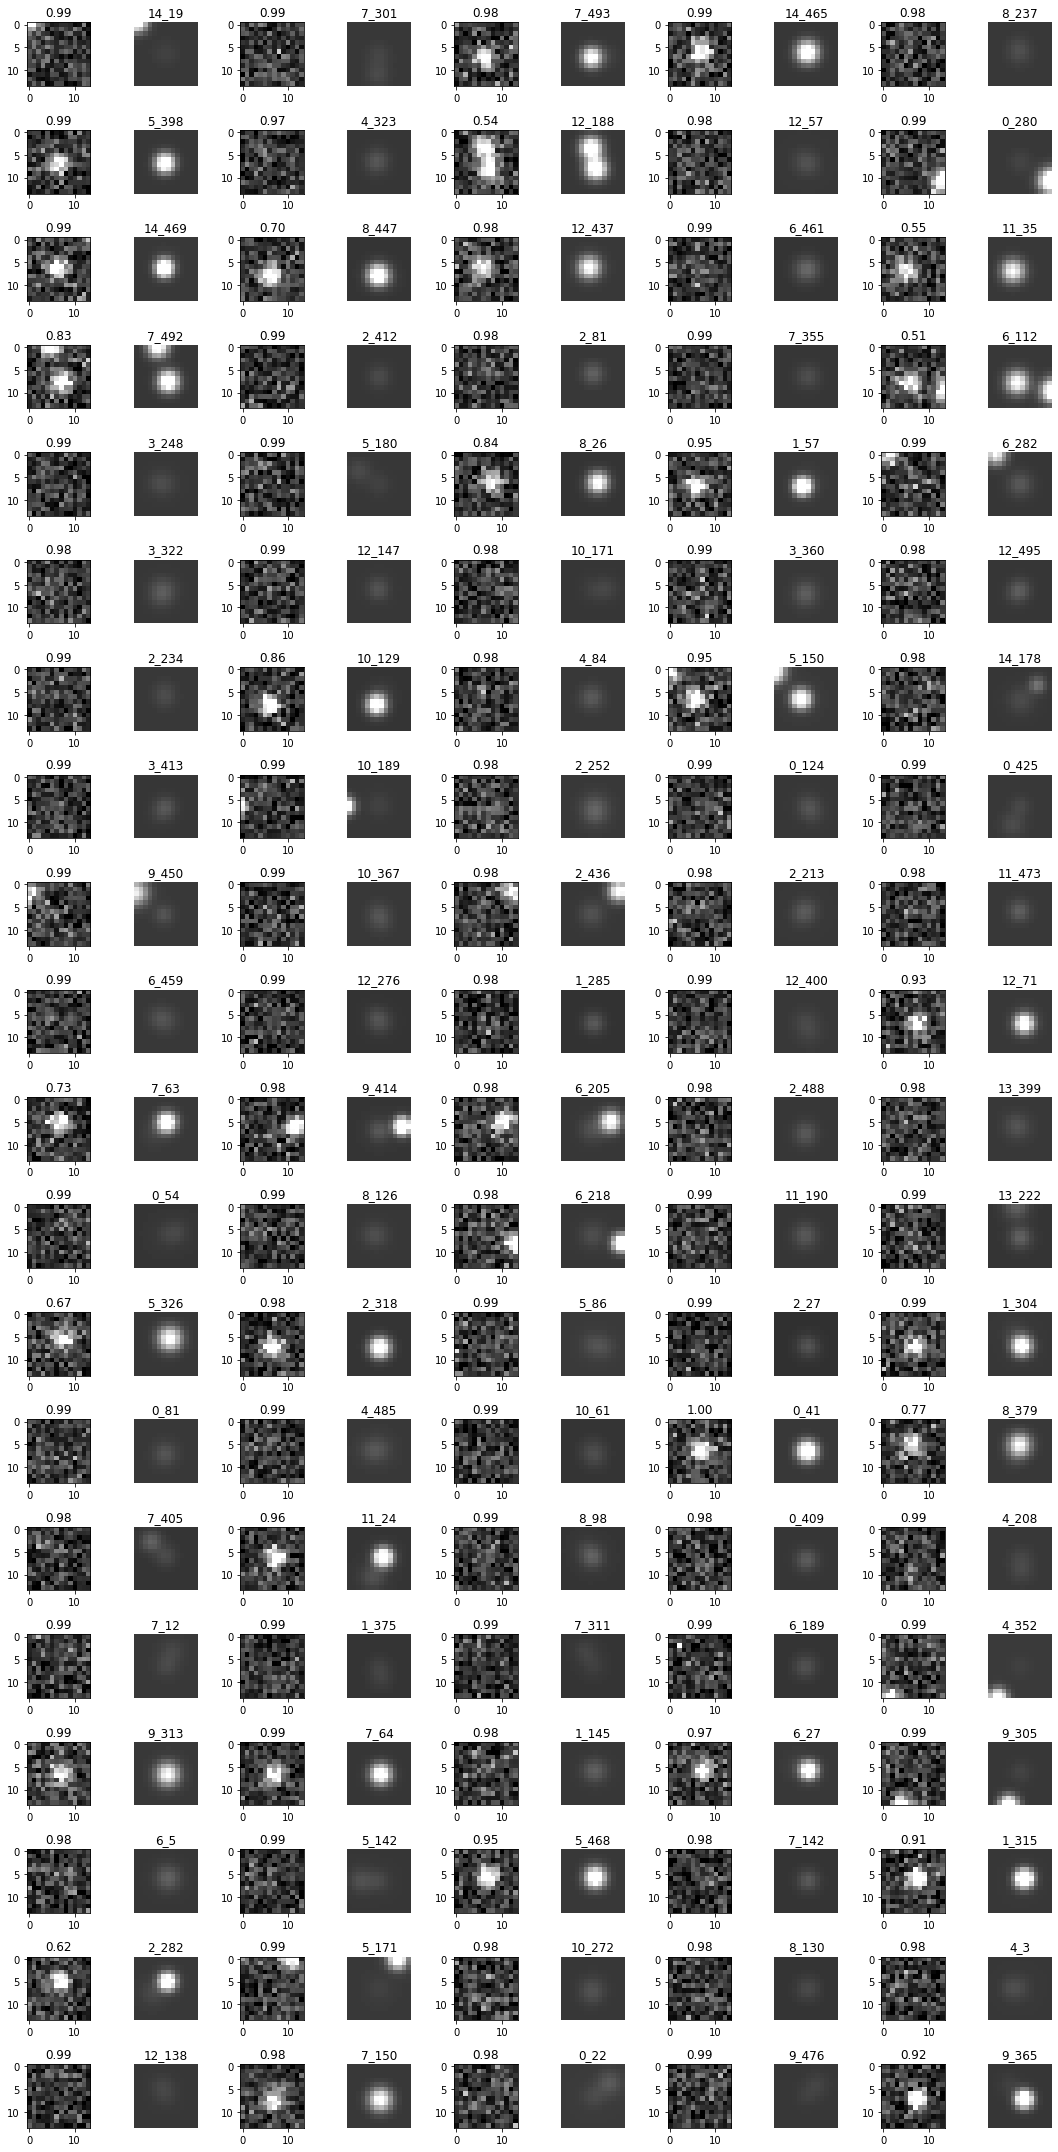

In [11]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)
idx = np.arange(len(n))
np.random.shuffle(idx)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,30))
for i in range(min(100, len(result))):
    j = idx[i]
    plt.subplot(20, 10, 2*i+1)
    
    gaussians = model.data_loc(
    param("d/h_loc").data[n[j], f[j]].masked_fill(model.m_probs[n[j], f[j], :, 1] < 0.5, 0.),
    param("d/w_mean").data[n[j], f[j]],
    param("d/x_mean").data[n[j], f[j]],
    param("d/y_mean").data[n[j], f[j]],
    n[j], f[j]).sum(-3)
    ideal = model.offset_mean + param("d/b_loc").data[n[j], f[j]] + gaussians
    plt.imshow(result[j].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.title("{:.2f}".format(model.z_marginal[n[j], f[j]]))
    
    plt.subplot(20, 10, 2*i+2)
    plt.title(f"{n[j]}_{f[j]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [37]:
threshold = np.logspace(-6, 0)
mcc = {}
for name in names:
    mcc[name] = [matthews_corrcoef((predictions[name]["z_prob"]>t).ravel(), labels[name]["z"].ravel()) for t in threshold]

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [45]:
sp_results = {}

for name in names:
    sp_results[name] = loadmat("/shared/centaur/data/height_data/h{}.mat".format(name))

In [46]:
scores_sp = pd.DataFrame(data={
    "spMCC": [matthews_corrcoef(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
    "spRecall": [recall_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
    "spPrecision": [precision_score(labels[name]["z"].ravel(), sp_results[name]["d"][:, 1]) for name in names],
    },
    index=names)
scores_sp

,spMCC,spRecall,spPrecision
0300,0.347883,0.166809,0.878378
0500,0.570095,0.420873,0.888087
0750,0.759349,0.685201,0.912301
1000,0.872431,0.858854,0.925346
1500,0.941323,0.974337,0.927524
2000,0.950915,0.984602,0.933496
3000,0.951547,0.980325,0.938575


In [77]:
hpd = hpdi(mcc, 0.99)
mean = mcc.mean(0)
hpd

tensor([[0.0269, 0.3425, 0.7561, 0.8810, 0.9108, 0.9166, 0.9223],
        [0.0711, 0.3899, 0.7873, 0.8999, 0.9294, 0.9357, 0.9409]])

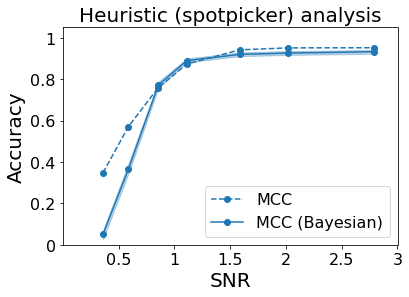

In [79]:
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.fill_between(snr, hpd[0], hpd[1], color="C0", alpha=0.3)
plt.plot(snr, mean, "o-", color="C0", label="MCC (Bayesian)")
plt.ylim(0,1.05)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.show()

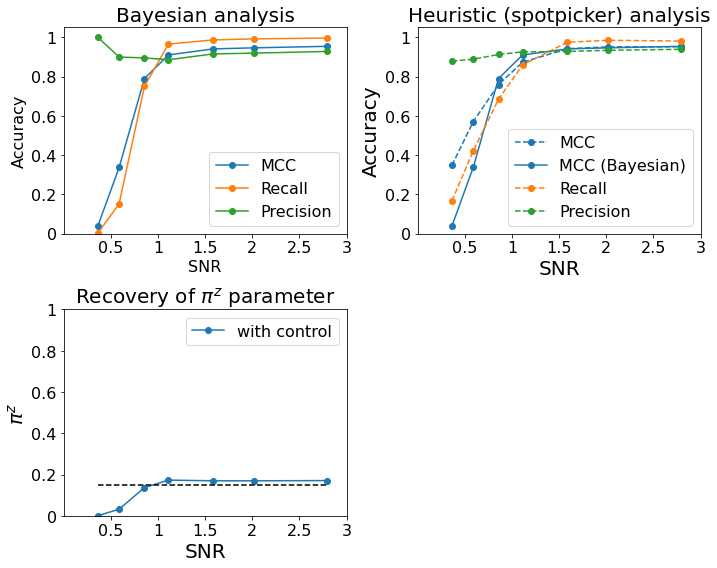

In [49]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.subplot(223)
plt.plot(snr, scores_v1p13["pi_1"], "o-", label="with control")
plt.plot([snr[0], snr[-1]], [float(pi_z)/100, float(pi_z)/100], "--", c="k")
plt.ylim(0,1)
plt.xlim(0,3)
plt.xlabel(r"SNR", fontsize=20)
plt.ylabel(r"$\pi^z$", fontsize=20)
plt.title(r"Recovery of $\pi^z$ parameter", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(1,7)*0.5)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

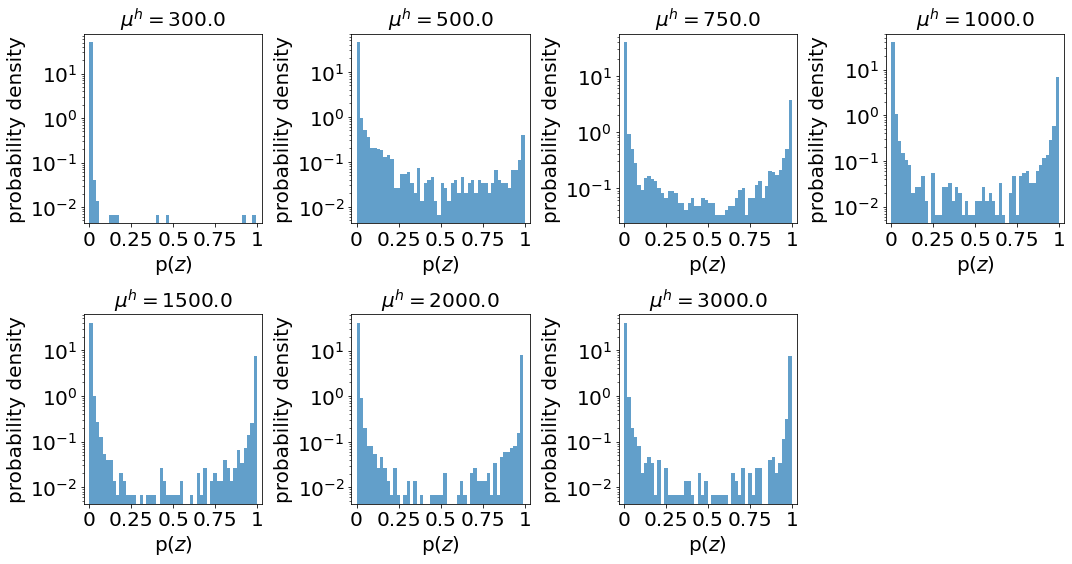

In [10]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[h]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

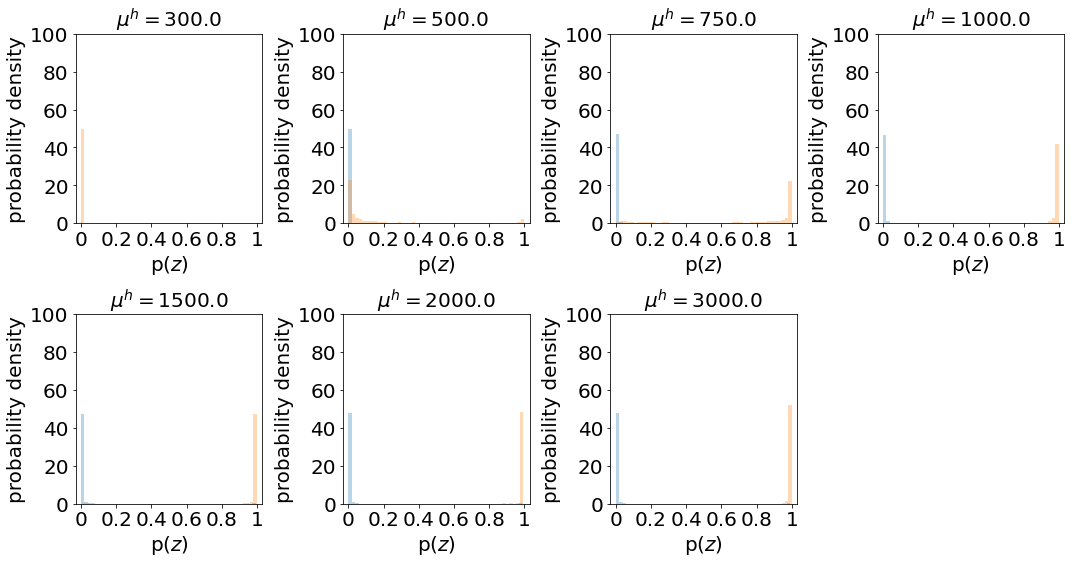

In [43]:
plt.figure(figsize=(15,15))
for i, h in enumerate(heights):
    plt.subplot(4, 4, i+1)
    mask = labels[h]["z"]
    #plt.hist(predictions[h]["z_prob"].ravel(), bins=50, density=True, alpha=0.3)
    plt.hist(predictions[h]["z_prob"][~mask], bins=50, density=True, alpha=0.3)
    plt.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3)
    plt.xlim(-0.03, 1.03)
    #plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    plt.ylim(0,100)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"$\mu^h={}$".format(float(h)), fontsize=20)

plt.tight_layout()
plt.show()

In [74]:
snr = np.array([0.37588992714881897,
 0.6264832615852356,
 0.9397249221801758,
 1.2529665231704712,
 1.8794498443603516,
 2.5059330463409424,
 3.758899688720703]
)

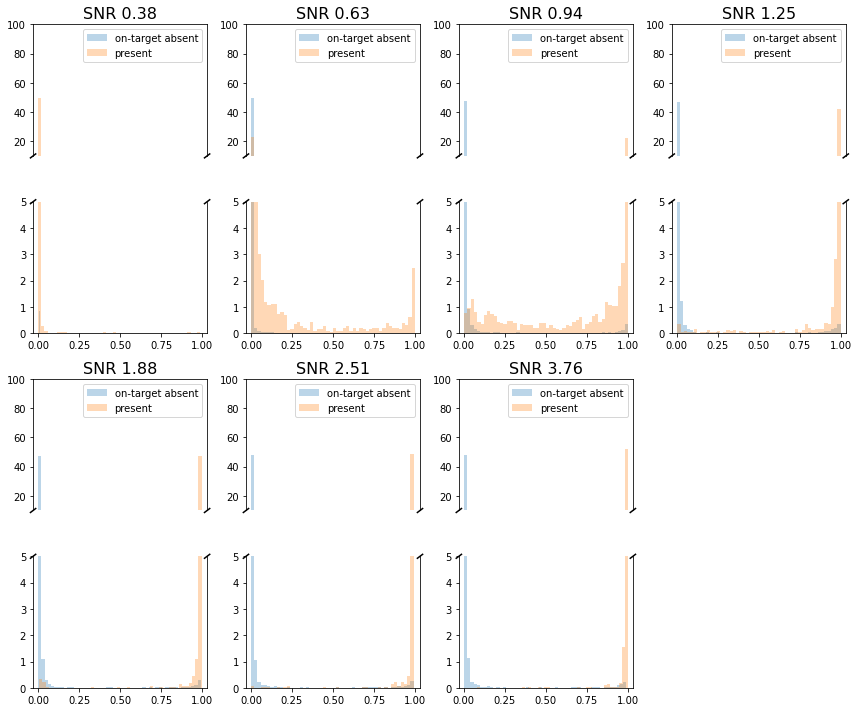

In [80]:
plt.figure(figsize=(12,10))
for i, h in enumerate(heights):
    ax = plt.subplot(4, 4, i+1+4*(i//4))
    mask = labels[h]["z"]
    ax.hist(predictions[h]["z_prob"][~mask], bins=50, density=True, alpha=0.3, label="on-target absent")
    ax.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3, label="present")
    ax.set_xlim(-0.03, 1.03)
    ax.set_ylim(10, 100.)  # outliers only
    #plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
    #plt.ylim(0,10)
    #plt.xticks(size=20)
    #plt.yticks(size=20)
    #plt.xlabel(r"p($z$)", fontsize=20)
    #plt.ylabel(r"probability density", fontsize=20)
    plt.title(r"SNR {:.2f}".format(snr[i]), fontsize=16)
    plt.legend()
    
    ax2 = plt.subplot(4, 4, i+1+4*(1+i//4))
    mask = labels[h]["z"]
    ax2.hist(predictions[h]["z_prob"][~mask], bins=50, density=True, alpha=0.3)
    ax2.hist(predictions[h]["z_prob"][mask], bins=50, density=True, alpha=0.3)
    ax2.set_xlim(-0.03, 1.03)
    ax2.set_ylim(0, 5.)  # most of the data
    
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    #ax.xaxis.tick_top()
    ax.xaxis.set_ticks([])
    ax.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.tight_layout()
plt.show()

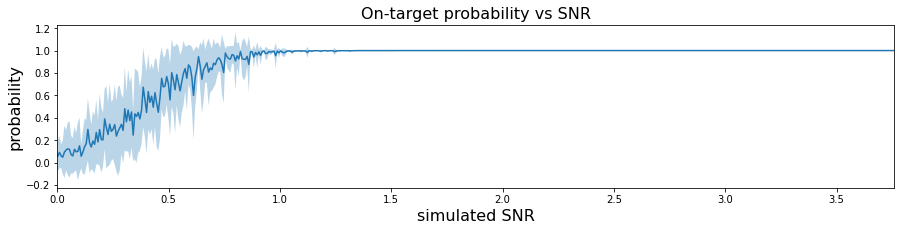

In [40]:
plt.figure(figsize=(15,3))
plt.plot(snr, model.z_marginal.mean(0))
plt.fill_between(
    snr,
    model.z_marginal.mean(0) - model.z_marginal.std(0),
    model.z_marginal.mean(0) + model.z_marginal.std(0),
    alpha=0.3
)
plt.xlim(0,3.76)
plt.title("On-target probability vs SNR", fontsize=16)
plt.xlabel("simulated SNR", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.show()

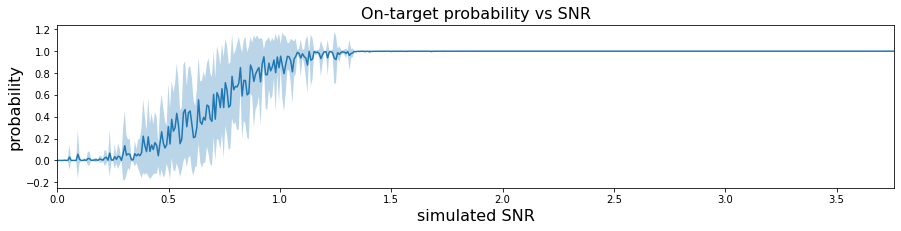

In [42]:
plt.figure(figsize=(15,3))
plt.plot(snr, model.z_marginal.mean(0))
plt.fill_between(
    snr,
    model.z_marginal.mean(0) - model.z_marginal.std(0),
    model.z_marginal.mean(0) + model.z_marginal.std(0),
    alpha=0.3
)
plt.xlim(0,3.76)
plt.title("On-target probability vs SNR", fontsize=16)
plt.xlabel("simulated SNR", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.show()

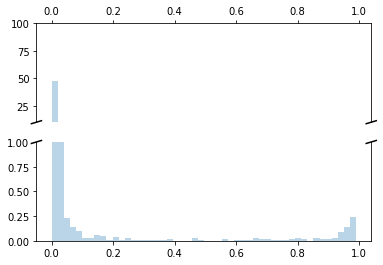

In [50]:
# If we were to simply plot pts, we'd lose most of the interesting
# details due to the outliers. So let's 'break' or 'cut-out' the y-axis
# into two portions - use the top (ax) for the outliers, and the bottom
# (ax2) for the details of the majority of our data
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
#ax.plot(pts)
#ax2.plot(pts)
ax.hist(predictions[h]["z_prob"][~mask], bins=50, density=True, alpha=0.3)
ax2.hist(predictions[h]["z_prob"][~mask], bins=50, density=True, alpha=0.3)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(10, 100.)  # outliers only
ax2.set_ylim(0, 1.)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

In [41]:
# load cosmos results
path_data = "/shared/centaur/data/simulations/lamda_data/hfloatpi100lamda0"
path_params = os.path.join(path_data, "runs/halfnormal/v1.1.5/S1/nocontrol/lr0.005/bs3")
model = SpotDetection(S=1, K=2)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

In [19]:
D = 14
background = 150
gain = torch.tensor(7.)
width = torch.tensor([1.4])

rv = dist.MultivariateNormal(
    torch.tensor([6.5, 6.5]),
    scale_tril=torch.eye(2) * width[..., None, None])

D_range = torch.arange(D, dtype=torch.float)
i_pixel, j_pixel = torch.meshgrid(D_range, D_range)
ij_pixel = torch.stack((i_pixel, j_pixel), dim=-1)

# calculate signal-to-noise ratio
heights = np.linspace(1,3000,500)
#snr = []
#for h in heights:
weights = rv.log_prob(ij_pixel).exp()
#print(weights.pow(2).sum().sqrt())
signal = (weights ** 2 * heights.reshape(-1,1,1)).sum((-2,-1))
noise = ((background) * gain).sqrt()
snr = signal / noise

In [31]:
from pyro.ops.stats import hpdi
xstd = AffineBeta(param("d/x_mean").data, param("d/size").data, -7.5, 7.5).sample((500,))[..., 0].std(0)

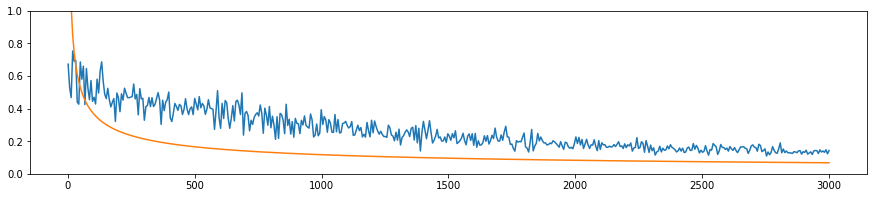

In [37]:
plt.figure(figsize=(15,3))
plt.plot(heights, xstd[0])
plt.plot(heights, np.sqrt(1.4**2*7/heights))
plt.ylim(0,1)
plt.show()

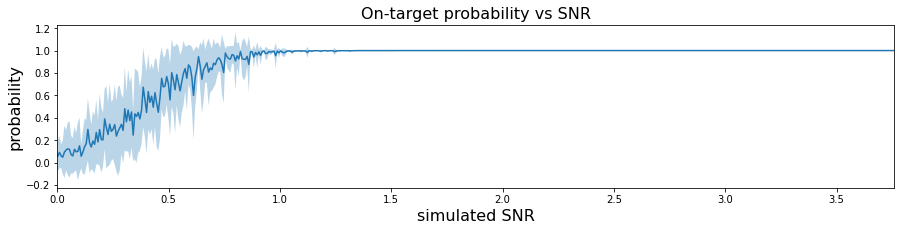

In [39]:
plt.figure(figsize=(15,3))
plt.plot(snr, model.z_marginal.mean(0))
plt.fill_between(
    snr,
    model.z_marginal.mean(0) - model.z_marginal.std(0),
    model.z_marginal.mean(0) + model.z_marginal.std(0),
    alpha=0.3
)
plt.xlim(0,3.76)
plt.title("On-target probability vs SNR", fontsize=16)
plt.xlabel("simulated SNR", fontsize=16)
plt.ylabel("probability", fontsize=16)
plt.show()

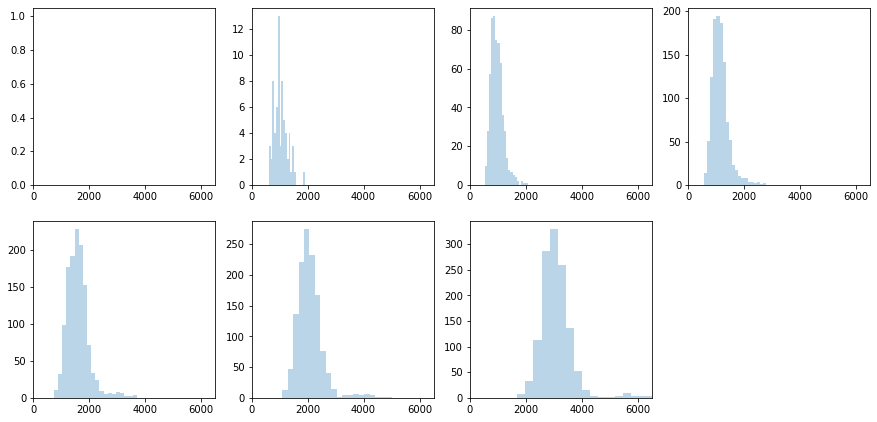

In [41]:
plt.figure(figsize=(15,15))
for i, name in enumerate(heights):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/h_loc").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 6500)
plt.show()

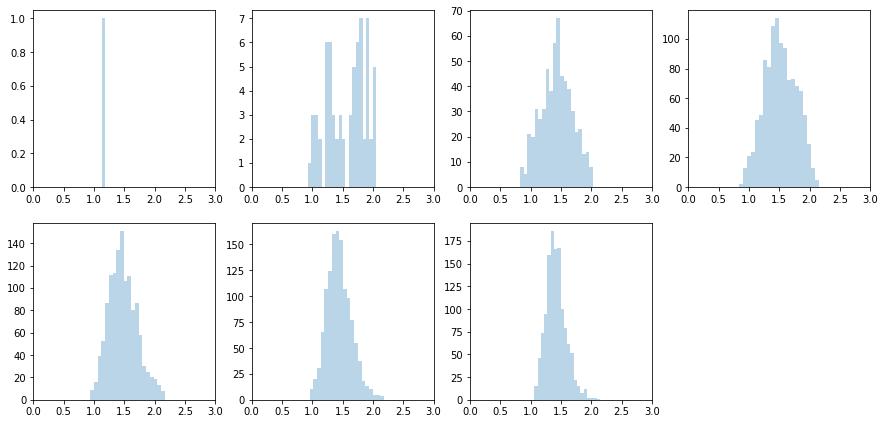

In [44]:
plt.figure(figsize=(15,15))
for i, name in enumerate(heights):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/w_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(0, 3)
plt.show()

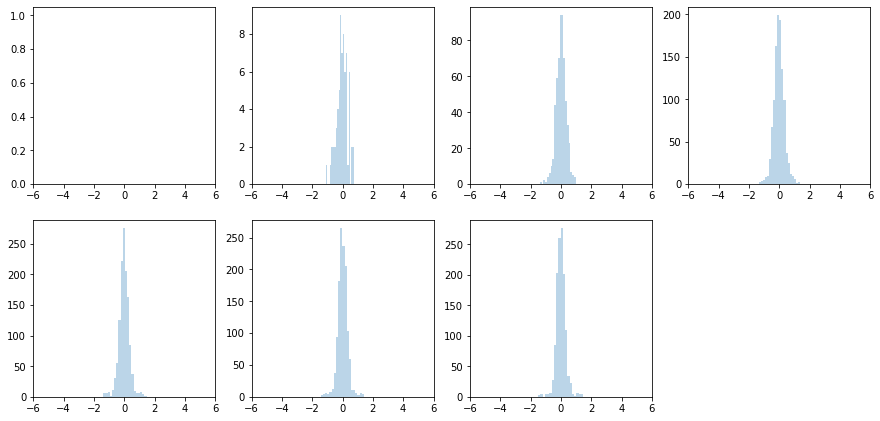

In [46]:
plt.figure(figsize=(15,15))
for i, name in enumerate(heights):
    plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/height_data/h{}pi15lamda15".format(name)
    params_last[name] = pd.read_csv(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params_last.csv"),
        header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/control/lr0.005/bs5/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist(param("d/x_mode").data[mask].numpy(), bins=20, alpha=0.3)
    plt.xlim(-6, 6)
plt.show()